## Project: Classifying Disaster-Related Tweets as Real or Fake

In this project we will monitor and analyze news on social media platforms to look for misinformation by building a deep learning text classification model that predicts which Tweets are about real disasters and which aren't. After performing some data exploration and  preprocessing we generated some visualization with WordCloud, we will build, train and evaluate several deep learning models for text classification.

Data Dictionary:

`id`: a unique identifier for each tweet

`keyword`: a particular keyword from the tweet (may be blank)

`location`: the location the tweet was sent from (may be blank)

`text`: the text of the tweet

`target`: denotes whether a tweet is about a real disaster (1) or not (0). This is the target variable.

![](https://images.unsplash.com/photo-1546422904-90eab23c3d7e?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1744&q=80)
__Photo by Filip Mishevski on Unsplash__

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [2]:
df=pd.read_csv("C:/Users/Denisa/Desktop/Project Apps/project 27/train.csv")

In [3]:
print(df.shape)
print(df.columns)

(7613, 5)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [6]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
print(df['keyword'].nunique()); print(df['location'].nunique()); print(df['text'].nunique()); print(df['target'].nunique());

221
3341
7503
2


### Data Exploration

Distribution of the target variable

In [8]:
df['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

Countplot to visualize the distribution of the target variable

C:\Users\Denisa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


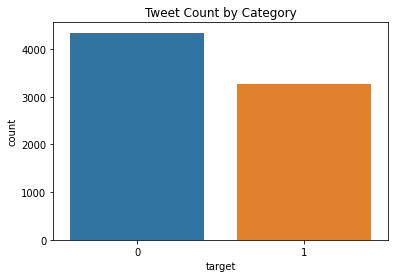

In [9]:
sns.countplot('target', data = df)
plt.title('Tweet Count by Category')
plt.show()

We can see approximately 43% of the tweets were news about real disasters, and we can also see that the data is balanced. 

We will drop the `id` column as it doesn't have any predictive power. We will also drop `keyword` and `location` for now since they have missing values or too many unique values.

### Text Preprocessing

Preprocessing text data is a necessary step in any NLP task, as it helps to clean and standardize the text, making it easier for the NLP algorithm to process. Furthermore, preprocessing can improve the accuracy of our results.

Preprocessing involves several steps that can help improve the overall quality of our text data. These steps include:

Coverting the text to lowercase
Removing punctuation from the text
Tokenizing the text
Removing stopwords from the text
Lemmatization (Stemming) of the text

In [10]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Denisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Denisa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Denisa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Next we will lowercase the text in the `text` column

In [11]:
df['text'] = df['text'].str.lower()
df['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

Next we will remove punctuations and numbers from the text

In [12]:
df['text'] = df['text'].str.lower()
df['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

Next we will tokenize the text into individual words

In [13]:
def tokenization(inputs):
    return word_tokenize(inputs)


df['text_tokenized'] = df['text'].apply(tokenization)
df['text_tokenized'].head()

0    [our, deeds, are, the, reason, of, this, #, ea...
1     [forest, fire, near, la, ronge, sask, ., canada]
2    [all, residents, asked, to, 'shelter, in, plac...
3    [13,000, people, receive, #, wildfires, evacua...
4    [just, got, sent, this, photo, from, ruby, #, ...
Name: text_tokenized, dtype: object

Next we will remove stopwords from the tokenized text

In [14]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):
    return [k for k in inputs if k not in stop_words]


df['text_stop'] = df['text_tokenized'].apply(stopwords_remove)
df['text_stop'].head()

0    [deeds, reason, #, earthquake, may, allah, for...
1     [forest, fire, near, la, ronge, sask, ., canada]
2    [residents, asked, 'shelter, place, ', notifie...
3    [13,000, people, receive, #, wildfires, evacua...
4    [got, sent, photo, ruby, #, alaska, smoke, #, ...
Name: text_stop, dtype: object

Next we will lemmatize the words in the tokenized text and join the lemmatized tokens into sentences and create a new column for the final processed text, `final`.

In [15]:
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]


df['text_lemmatized'] = df['text_stop'].apply(lemmatization)
df['text_lemmatized'].head()

# Joining Tokens into Sentences
df['final'] = df['text_lemmatized'].str.join(' ')
df['final'].head()

0       deeds reason # earthquake may allah forgive us
1              forest fire near la ronge sask . canada
2    residents ask 'shelter place ' notify officer ...
3    13,000 people receive # wildfires evacuation o...
4    get send photo ruby # alaska smoke # wildfires...
Name: final, dtype: object

In [16]:
df.head()

,id,keyword,location,text,target,text_tokenized,text_stop,text_lemmatized,final
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,"[our, deeds, are, the, reason, of, this, #, ea...","[deeds, reason, #, earthquake, may, allah, for...","[deeds, reason, #, earthquake, may, allah, for...",deeds reason # earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]",forest fire near la ronge sask . canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, 'shelter, in, plac...","[residents, asked, 'shelter, place, ', notifie...","[residents, ask, 'shelter, place, ', notify, o...",residents ask 'shelter place ' notify officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #, wildfires, evacua...","[13,000, people, receive, #, wildfires, evacua...","[13,000, people, receive, #, wildfires, evacua...","13,000 people receive # wildfires evacuation o..."
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ...","[got, sent, photo, ruby, #, alaska, smoke, #, ...","[get, send, photo, ruby, #, alaska, smoke, #, ...",get send photo ruby # alaska smoke # wildfires...


### Visualization with WordCloud

Next we will create a new dataframe by filtering the resulting dataframe of the previous exercise, to only include tweets that indicate a disaster tweet. After this, we will visualizing the most frequent words in the dataset using WordCloud to get a sense of the overall theme of the text dataset, to find parrerns in the data, to spot errors.

In [17]:
data_disaster = df[df['target'] == 1]

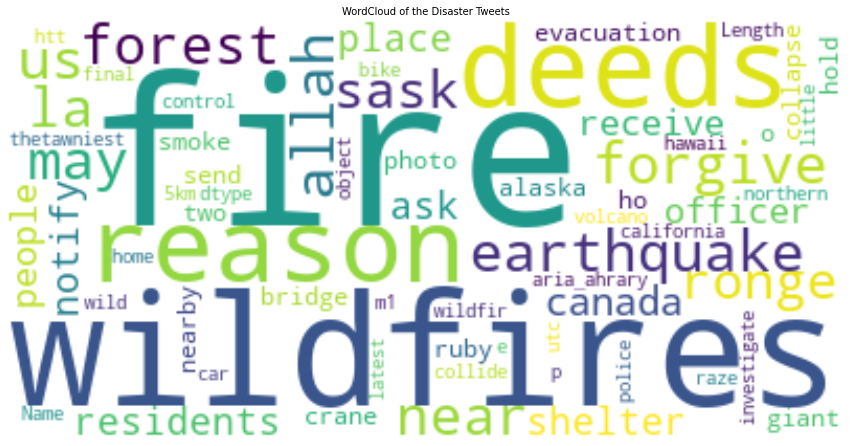

In [18]:
from wordcloud import WordCloud

WordCloud_disaster = WordCloud(max_words=500,
                                  random_state=100,background_color='white',
                                  collocations=True).generate(str((data_disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_disaster, interpolation='bilinear')
plt.title('WordCloud of the Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

Next, we will create a new dataframe that only include tweets that are not related to disasters

In [19]:
data_not_disaster = df[df['target'] == 0]

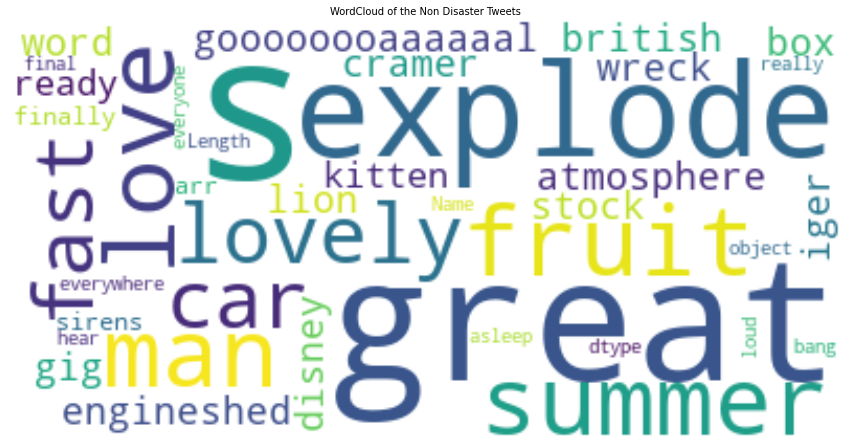

In [20]:

WordCloud_not_disaster = WordCloud(max_words=500,
                                      random_state=100, background_color='white',
                                      collocations=True).generate(str((data_not_disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_not_disaster, interpolation='bilinear')
plt.title('WordCloud of the Non Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

### Build a Shallow Neural Network

Now that we are done with preprocessing and text visualization, we will start with a simple model, a network that consists of two main layers: a vectorizer and an embedding layer. 

In [21]:
#Create an array of the target (dependent) variable and an array for the predictor (independent) variables
X = df['final']
y = df['target']

print(X.head())
print(y.head())

0       deeds reason # earthquake may allah forgive us
1              forest fire near la ronge sask . canada
2    residents ask 'shelter place ' notify officer ...
3    13,000 people receive # wildfires evacuation o...
4    get send photo ruby # alaska smoke # wildfires...
Name: final, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6090,) (6090,)
Testing set shape: (1523,) (1523,)


We will instantiate a model with the Keras Sequential API in TensorFlow, we will add an Input layer, followed by the vectorizer and the embedding layer. The TextVectorization layer takes raw text as itsinput and converts it into numerical values that are suitable for use in machine learning models.The Embedding layer in TensorFlow is responsible for mapping words to a vector of numbers to better capture semantic relationship between words.

In [23]:
max_tokens = 7500
input_length = 128
output_dim = 128

In [24]:
vectorizer_layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode='int', standardize='lower_and_strip_punctuation', output_sequence_length=input_length)
vectorizer_layer.adapt(X_train)

In [25]:
#Creating and Embedding Layer:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(input_dim=max_tokens,
                            output_dim=output_dim,
                            input_length=input_length)

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer),
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, verbose=2)
model.evaluate(X_test,y_test)


Epoch 1/10
191/191 - 3s - loss: 0.6802 - accuracy: 0.5773 - 3s/epoch - 14ms/step
Epoch 2/10
191/191 - 2s - loss: 0.6752 - accuracy: 0.5805 - 2s/epoch - 11ms/step
Epoch 3/10
191/191 - 2s - loss: 0.6746 - accuracy: 0.5798 - 2s/epoch - 10ms/step
Epoch 4/10
191/191 - 2s - loss: 0.6736 - accuracy: 0.5836 - 2s/epoch - 10ms/step
Epoch 5/10
191/191 - 2s - loss: 0.6726 - accuracy: 0.5837 - 2s/epoch - 11ms/step
Epoch 6/10
191/191 - 2s - loss: 0.6725 - accuracy: 0.5838 - 2s/epoch - 11ms/step
Epoch 7/10
191/191 - 2s - loss: 0.6737 - accuracy: 0.5817 - 2s/epoch - 10ms/step
Epoch 8/10
191/191 - 2s - loss: 0.6709 - accuracy: 0.5838 - 2s/epoch - 10ms/step
Epoch 9/10
191/191 - 2s - loss: 0.6712 - accuracy: 0.5839 - 2s/epoch - 10ms/step
Epoch 10/10
191/191 - 2s - loss: 0.6710 - accuracy: 0.5840 - 2s/epoch - 10ms/step
48/48 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5823


[0.6760250926017761, 0.5823313593864441]

We achieved an accuracy of approximately 58% on both the training set and the test set.

### Build a Multilayer Deep Text Classification Model

Next we will build a multilayer deep neural network. We will add an Input layer, followed by the vectorizer and the embedding layer, then we will add several dense layers after the embedding layer. We will initialize a GlobalAveragePooling1D Layer to help standardize our data so that our model gives results that are more reliable while reducing complexity so that the model learns faster and better. Also we plan to add a Dropout layer to implement some regularization and prevent overfitting. Finally, we will experiment with other regularization techniques (Lasso and Ridge regularization) and implement them to each layer to help the model to generalize better to new unseen data and prevent overfitting.

In [27]:
from tensorflow.keras.regularizers import L1, L2, L1L2
model_regularized = tf.keras.models.Sequential()
model_regularized.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_regularized.add(vectorizer_layer)
model_regularized.add(embedding_layer)
model_regularized.add(tf.keras.layers.GlobalAveragePooling1D())
model_regularized.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L1(0.0005)))
model_regularized.add(tf.keras.layers.Dropout(0.6))
model_regularized.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L1L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_regularized.fit(X_train, y_train, epochs=10, verbose=2)
model_regularized.evaluate(X_test, y_test)

Epoch 1/10
191/191 - 3s - loss: 1.5900 - accuracy: 0.6146 - 3s/epoch - 17ms/step
Epoch 2/10
191/191 - 2s - loss: 1.2954 - accuracy: 0.7880 - 2s/epoch - 12ms/step
Epoch 3/10
191/191 - 2s - loss: 1.0285 - accuracy: 0.8700 - 2s/epoch - 11ms/step
Epoch 4/10
191/191 - 2s - loss: 0.8357 - accuracy: 0.8901 - 2s/epoch - 11ms/step
Epoch 5/10
191/191 - 2s - loss: 0.6928 - accuracy: 0.9002 - 2s/epoch - 11ms/step
Epoch 6/10
191/191 - 2s - loss: 0.5998 - accuracy: 0.9008 - 2s/epoch - 11ms/step
Epoch 7/10
191/191 - 2s - loss: 0.5335 - accuracy: 0.9059 - 2s/epoch - 11ms/step
Epoch 8/10
191/191 - 2s - loss: 0.4905 - accuracy: 0.9049 - 2s/epoch - 10ms/step
Epoch 9/10
191/191 - 2s - loss: 0.4588 - accuracy: 0.9074 - 2s/epoch - 10ms/step
Epoch 10/10
191/191 - 2s - loss: 0.4366 - accuracy: 0.9100 - 2s/epoch - 10ms/step
48/48 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.8017


[0.6483386158943176, 0.8017071485519409]

The additional dense layers (with Lasso and Ridge regularization), the standardization of the data and the dropout layer had a positive impact on the model. We achieved an accuracy of approximately 91% on the training set and 80% on the test set.

### Building a Multilayer Bidirectional LSTM Model

Next we will build a multilayer bidirectional LSTM model. Sequence models are powerful tools when we have to deal with sequential data such as text. We will start by adding an input layer, followed by the vectorizer and the embedding layer. We will add multiple Bidirectional LSTM layers (that retain a memory of both future and past context while processing each token in a sequence, enabling them to make more accurate predictions for text classification tasks) with different units after the embedding layer. Then we will add some dense layers after the Bidirectional LSTM layers.

In [28]:
ml_bi_lstm = Sequential()
ml_bi_lstm.add(Input(shape=(1,), dtype=tf.string))
ml_bi_lstm.add(vectorizer_layer)
ml_bi_lstm.add(embedding_layer)
ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(64)))
ml_bi_lstm.add(Dense(64, activation='elu', kernel_regularizer=L1L2(0.0001)))
ml_bi_lstm.add(Dense(32, activation='elu', kernel_regularizer=L2(0.0001)))
ml_bi_lstm.add(Dense(8, activation='elu', kernel_regularizer=L2(0.0005)))
ml_bi_lstm.add(Dense(8, activation='elu'))
ml_bi_lstm.add(Dense(4, activation='elu'))
ml_bi_lstm.add(Dense(1, activation='sigmoid'))
opt = RMSprop(learning_rate=0.0001, rho=0.8, momentum=0.9)
ml_bi_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
ml_bi_lstm.fit(X_train, y_train, epochs=10)
test_loss, test_acc = ml_bi_lstm.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

Epoch 1/10
191/191 [==============================] - 122s 590ms/step - loss: 0.3505 - accuracy: 0.9007
Epoch 2/10
191/191 [==============================] - 109s 573ms/step - loss: 0.2708 - accuracy: 0.9159
Epoch 3/10
191/191 [==============================] - 111s 580ms/step - loss: 0.2735 - accuracy: 0.9015
Epoch 4/10
191/191 [==============================] - 109s 572ms/step - loss: 0.2382 - accuracy: 0.9166
Epoch 5/10
191/191 [==============================] - 110s 578ms/step - loss: 0.2133 - accuracy: 0.9268
Epoch 6/10
191/191 [==============================] - 112s 589ms/step - loss: 0.1988 - accuracy: 0.9281
Epoch 7/10
191/191 [==============================] - 109s 573ms/step - loss: 0.1885 - accuracy: 0.9355
Epoch 8/10
191/191 [==============================] - 108s 565ms/step - loss: 0.1707 - accuracy: 0.9424
Epoch 9/10
191/191 [==============================] - 108s 568ms/step - loss: 0.1599 - accuracy: 0.9440
Epoch 10/10
48/48 [==============================] - 14s 264ms/s

The bidirectional LSTM layers enabled the model to gather more context for pattern recognition and prediction making so we
achieved an accuracy of approximately 94% on the training set and 78% on the test set. Howeever there is still a gap between the training and the test set that indicates signs of overfitting.

### Building a Transformer Model

Although we saw respectable progress with LSTM models, there is still room for improvement. Next we will transition from building LSTM-based text classification models to exploring a new, powerful approach: transformers. They tend to outperform sequence models in text classification tasks due to their attention mechanisms, which focus on the most important parts of a sentence when predicting, they have faster training times, better scalability, being more computational efficient.

In [29]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Tokenize the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.constant(y_train.values, dtype=tf.int32)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.constant(y_test.values, dtype=tf.int32)
))

train_dataset = train_dataset.shuffle(len(X_train)).batch(16)
test_dataset = test_dataset.batch(16)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [30]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.fit(train_dataset, epochs=10)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test set accuracy: {test_acc}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
381/381 [==============================] - 883s 2s/step - loss: 0.4605 - accuracy: 0.8003
Epoch 2/10
381/381 [==============================] - 1055s 3s/step - loss: 0.3347 - accuracy: 0.8649
Epoch 3/10
381/381 [==============================] - 959s 3s/step - loss: 0.2365 - accuracy: 0.9074
Epoch 4/10
381/381 [==============================] - 894s 2s/step - loss: 0.1423 - accuracy: 0.9478
Epoch 5/10
381/381 [==============================] - 872s 2s/step - loss: 0.1128 - accuracy: 0.9598
Epoch 6/10
381/381 [==============================] - 868s 2s/step - loss: 0.0864 - accuracy: 0.9657
Epoch 7/10
381/381 [==============================] - 858s 2s/step - loss: 0.0641 - accuracy: 0.9729
Epoch 8/10
381/381 [==============================] - 860s 2s/step - loss: 0.0564 - accuracy: 0.9795
Epoch 9/10
381/381 [==============================] - 860s 2s/step - loss: 0.0452 - accuracy: 0.9819
Epoch 10/10
96/96 [==============================] - 54s 546ms/step - loss: 0.8012 - accur

With the transformer model we got satisfacatory results (98% on the training set and 81% on the test set).

### Conclusions

In this project we built a deep learning text classification model that predicts which Tweets are about real disasters and which aren't.
We built and evaluated different models like:
* Shallow Neural Network
* Multilayer Deep Text Classification Model
* Multilayer Bidirectional LSTM Model
* Transformer Model
and we got the most satisfacatory results with the transformer model.

Finding a desirable architecture is an iterative process that often requires some trial and error. Some next steps we can take in the future are:
* Hyperparameter Optimization(learning rate and number of layers etc.)

* Optimizers and Loss Functions

* Try another transformer model  instead of sticking to the classic distilbert-base-uncased T

* Other Performance Metrics to get a more nuanced view of your model's strengths and weaknesses

* Domain Specific Knowledge